In [1]:
import sys
import os
sys.path.append('..')
sys.path.append('../whitebox-analyses')
sys.path.append('../whitebox-analyses/nathan_scripts')
sys.path.append('../whitebox-analyses/scripts')

import numpy as np
import matplotlib.pyplot as plt
from attention_analysis.attn_supp_funcs import get_suppression_KL_matrix
from attention_analysis.receiver_head_funcs import get_problem_text_sentences
from prep_suppression_mtxs import get_all_problem_numbers
from pkld.utils import get_cache_fp

from detailed_suppression_analysis import analyze_suppression_detailed
from pkld.utils import get_cache_fp
import os

/nlp/u/nathu/thought-anchors/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir('/nlp/u/nathu/thought-anchors')
print("Current working directory:", os.getcwd())

Current working directory: /juice2/u/nathu/thought-anchors


In [3]:


def is_analysis_cached(problem_num, model_name="llama-8b", is_correct=True, cumulative=False):
    """Check if analysis results are cached."""
    # Pass as kwargs to match how the function was originally called
    temp_cache_path = get_cache_fp(
        analyze_suppression_detailed,
        args=(),  # Empty args
        kwargs={
            'problem_num': problem_num,
            'model_name': model_name,
            'is_correct': is_correct,
            'device_map': "auto",
            'cumulative': cumulative
        },
        max_fn_len=128
    )

    filename = temp_cache_path.name
    correct_cache_dir = "/nlp/u/nathu/thought-anchors/whitebox-analyses/nathan_scripts/.pkljar/detailed_suppression_analysis/analyze_suppression_detailed"
    print("Checking cache path:", os.path.join(correct_cache_dir, filename))
    correct_cache_path = os.path.join(correct_cache_dir, filename)

    return os.path.exists(correct_cache_path)

is_analysis_cached(problem_num=1591, model_name="llama-8b", is_correct=True, cumulative=False)

Checking cache path: /nlp/u/nathu/thought-anchors/whitebox-analyses/nathan_scripts/.pkljar/detailed_suppression_analysis/analyze_suppression_detailed/_cum-False__dev-auto__is_-True__mod-llama-8b__pro-1591_.pkl


True

In [ ]:


def create_causal_mask_and_distances(detailed_results):
        
    sentence_boundaries = detailed_results['metadata']['sentence_boundaries']
    n_sentences, n_tokens = detailed_results['kl_matrix_t1'].shape
    # Map each token position to its sentence index (-1 if unassigned)
    in_cot_mask = np.zeros(n_tokens, dtype=bool)
    token_to_sentence = np.full(n_tokens, -1, dtype=int)
    for sent_idx, (start, end) in enumerate(sentence_boundaries):
        if end <= n_tokens:
            token_to_sentence[start:end] = sent_idx
            in_cot_mask[start:end] = True
        if sent_idx == n_sentences - 1:
            token_to_sentence[end:] = sent_idx + 1  # Assign remaining tokens to last sentence


    #distance between last masked sentance and each token. distance = 0 if token is in masked sentance, 1 if in next sentance, etc.
    sentence_distances = token_to_sentence - np.arange(n_sentences)[:, None]

    #token distances, number of tokens between last masked token and each token
    sentence_ends = np.array([sb[1] for sb in sentence_boundaries])
    token_distances = np.arange(n_tokens)[None, :] + 1 - sentence_ends[:, None]
    assert ((sentence_distances > 0) == (token_distances > 0)).all()
    causal_mask = sentence_distances > 0
    return {
        'causal_mask': causal_mask,
        'sentence_distances': sentence_distances,
        'token_distances': token_distances,
        'in_cot_mask': in_cot_mask
    }

def load_data(
    problem_num, 
    model_name, 
    is_correct,
    cumulative):
    if is_analysis_cached(
        problem_num=problem_num, 
        model_name=model_name, 
        is_correct=is_correct,
        cumulative=cumulative,
    ):
        # Load the detailed analysis results
        detailed_results = analyze_suppression_detailed(
            problem_num=problem_num, 
            model_name=model_name, 
            is_correct=is_correct,
            cumulative=cumulative,
        )

        
        masking_info = create_causal_mask_and_distances(detailed_results)
        detailed_results.update(masking_info)
        return detailed_results
    else:
        print(f"Analysis not cached for problem {problem_num}, model {model_name}, is_correct={is_correct}, cumulative={cumulative}")
        return None

In [5]:
cumulative_masking_results = {}
single_step_masking_results = {}
for problem_id, is_correct in get_all_problem_numbers('llama-8b', include_incorrect=True):
    for cummulative in [False, True]:
        #print(f"Loading problem {problem_id}, is_correct={is_correct}")
        try:
            result = load_data(
                problem_num=problem_id,
                model_name='llama-8b',
                is_correct=is_correct,
                cumulative=cummulative
            )
            if result is not None:
                if cummulative:
                    cumulative_masking_results[(problem_id, is_correct)] = result
                else:
                    single_step_masking_results[(problem_id, is_correct)] = result
        except Exception as e:
            print(f"Error loading data for problem {problem_id}, is_correct={is_correct}: {e}")
        print(f"Loaded problem {problem_id}, is_correct={is_correct}, cumulative={cummulative}")
print("Total loaded results:", len(cumulative_masking_results), len(single_step_masking_results))


Checking cache path: /nlp/u/nathu/thought-anchors/whitebox-analyses/nathan_scripts/.pkljar/detailed_suppression_analysis/analyze_suppression_detailed/_cum-False__dev-auto__is_-False__mod-llama-8b__pro-330_.pkl
Analysis not cached for problem 330, model llama-8b, is_correct=False, cumulative=False
Loaded problem 330, is_correct=False, cumulative=False
Checking cache path: /nlp/u/nathu/thought-anchors/whitebox-analyses/nathan_scripts/.pkljar/detailed_suppression_analysis/analyze_suppression_detailed/_cum-True__dev-auto__is_-False__mod-llama-8b__pro-330_.pkl
Analysis not cached for problem 330, model llama-8b, is_correct=False, cumulative=True
Loaded problem 330, is_correct=False, cumulative=True
Checking cache path: /nlp/u/nathu/thought-anchors/whitebox-analyses/nathan_scripts/.pkljar/detailed_suppression_analysis/analyze_suppression_detailed/_cum-False__dev-auto__is_-True__mod-llama-8b__pro-330_.pkl
Loaded problem 330, is_correct=True, cumulative=False
Checking cache path: /nlp/u/nathu/

# look at aggregate stats

Total valid data points: 1097076
Sentence distance range: 1 to 203
Token distance range: 1 to 4337
KL range: 8.36e-09 to 5.57e+00
TV range: 7.58e-06 to 9.96e-01


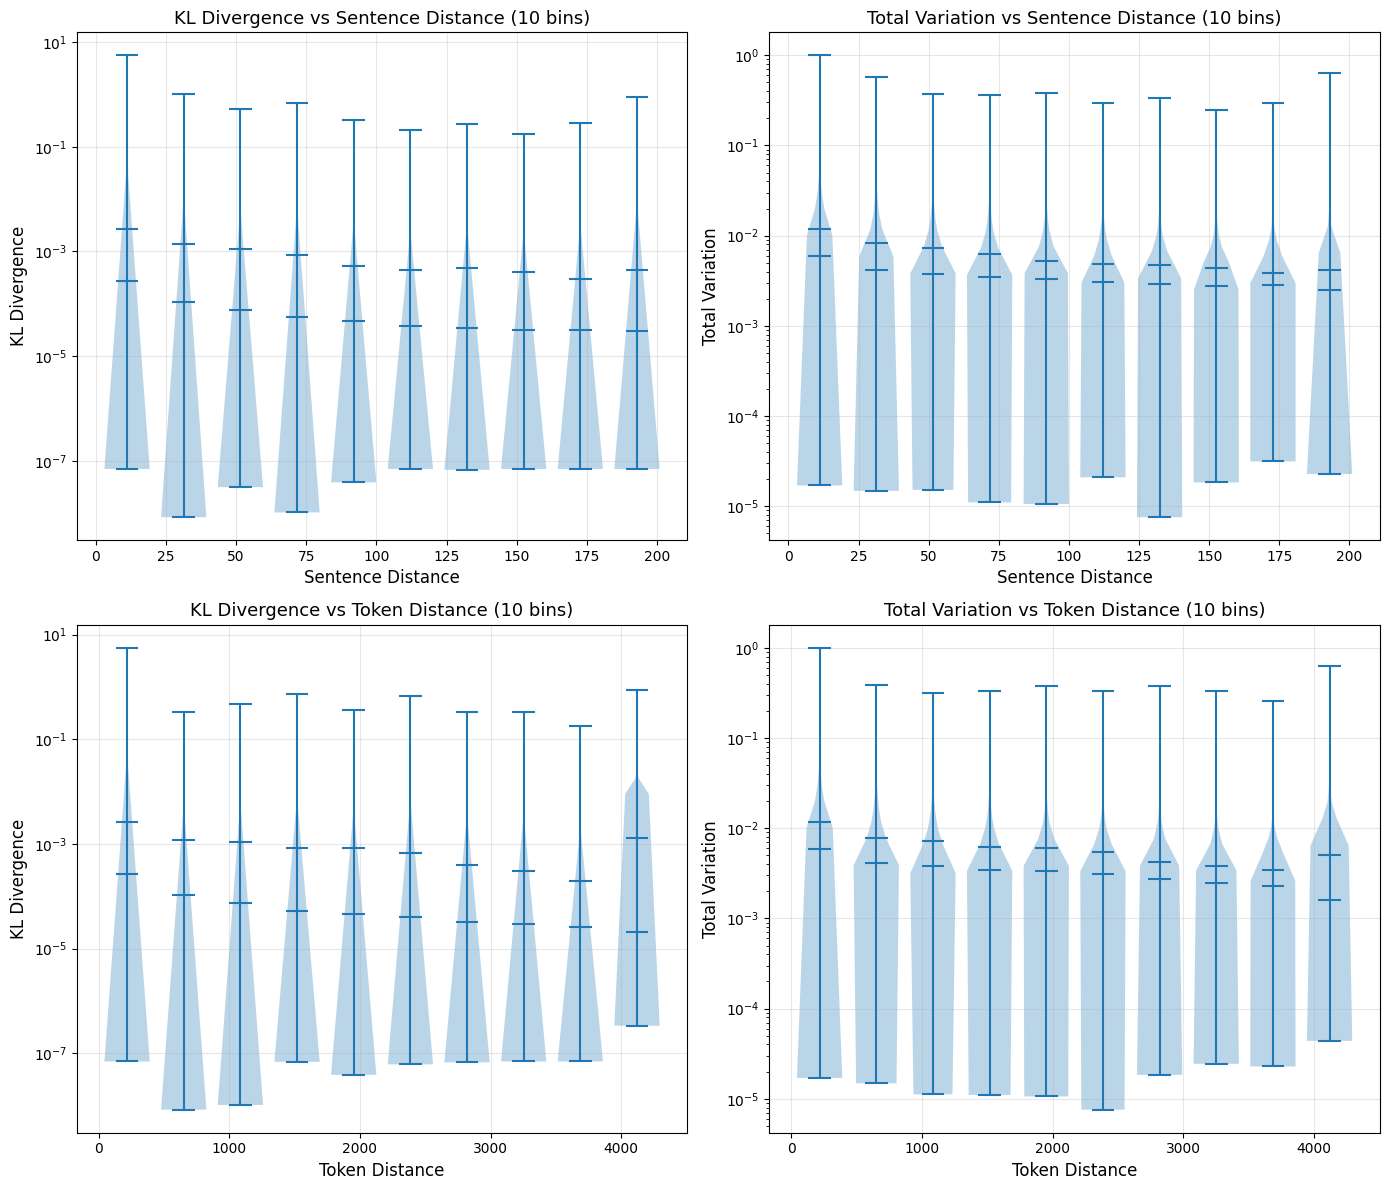

In [12]:
# Distance vs Error Analysis
import matplotlib.pyplot as plt
import numpy as np

# Aggregate data across all problems (using single step masking)
all_kl_t1 = []
all_tv_t1 = []
all_sentence_distances = []
all_token_distances = []

for (problem_id, is_correct), result in single_step_masking_results.items():
    if result is None:
        continue
    
    # Get causal mask
    causal_mask = result['causal_mask']
    
    # Extract data only where causal mask is True
    kl_masked = result['kl_matrix_t1'][causal_mask]
    tv_masked = result['tv_matrix_t1'][causal_mask]
    sent_dist_masked = result['sentence_distances'][causal_mask]
    token_dist_masked = result['token_distances'][causal_mask]
    
    # Filter out NaN and extreme values
    valid_mask = ~np.isnan(kl_masked) & ~np.isnan(tv_masked) & (kl_masked < 1000) & (kl_masked > 0) & (tv_masked > 0)
    
    all_kl_t1.extend(kl_masked[valid_mask])
    all_tv_t1.extend(tv_masked[valid_mask])
    all_sentence_distances.extend(sent_dist_masked[valid_mask])
    all_token_distances.extend(token_dist_masked[valid_mask])

# Convert to arrays
all_kl_t1 = np.array(all_kl_t1)
all_tv_t1 = np.array(all_tv_t1)
all_sentence_distances = np.array(all_sentence_distances)
all_token_distances = np.array(all_token_distances)

print(f"Total valid data points: {len(all_kl_t1)}")
print(f"Sentence distance range: {all_sentence_distances.min()} to {all_sentence_distances.max()}")
print(f"Token distance range: {all_token_distances.min()} to {all_token_distances.max()}")
print(f"KL range: {all_kl_t1.min():.2e} to {all_kl_t1.max():.2e}")
print(f"TV range: {all_tv_t1.min():.2e} to {all_tv_t1.max():.2e}")

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Row 1: Sentence distance violin plots (10 bins)
sent_bins = np.linspace(all_sentence_distances.min(), all_sentence_distances.max(), 11)
sent_bin_indices = np.digitize(all_sentence_distances, sent_bins) - 1

for i, (y_data, y_label) in enumerate([(all_kl_t1, 'KL Divergence'), 
                                       (all_tv_t1, 'Total Variation')]):
    # Prepare data for violin plot
    violin_data = []
    positions = []
    labels = []
    for bin_idx in range(len(sent_bins) - 1):
        mask = sent_bin_indices == bin_idx
        count = np.sum(mask)
        if count > 0:  # Only include bins with data
            violin_data.append(y_data[mask])
            bin_center = (sent_bins[bin_idx] + sent_bins[bin_idx + 1]) / 2
            positions.append(bin_center)
            labels.append(f'{sent_bins[bin_idx]:.0f}-{sent_bins[bin_idx+1]:.0f}\n(n={count})')
    
    # Create violin plot
    parts = axes[0, i].violinplot(violin_data, positions=positions, widths=0.8*(positions[1]-positions[0]), 
                                   showmeans=True, showmedians=True)
    axes[0, i].set_xlabel('Sentence Distance', fontsize=12)
    axes[0, i].set_ylabel(y_label, fontsize=12)
    axes[0, i].set_yscale('log')
    axes[0, i].set_title(f'{y_label} vs Sentence Distance (10 bins)', fontsize=13)
    axes[0, i].grid(True, alpha=0.3)

# Row 2: Token distance violin plots (10 bins, linear)
token_bins = np.linspace(all_token_distances.min(), all_token_distances.max(), 11)
token_bin_indices = np.digitize(all_token_distances, token_bins) - 1

for i, (y_data, y_label) in enumerate([(all_kl_t1, 'KL Divergence'),
                                       (all_tv_t1, 'Total Variation')]):
    # Prepare data for violin plot
    violin_data = []
    positions = []
    labels = []
    for bin_idx in range(len(token_bins) - 1):
        mask = token_bin_indices == bin_idx
        count = np.sum(mask)
        if count > 0:  # Only include bins with data
            violin_data.append(y_data[mask])
            bin_center = (token_bins[bin_idx] + token_bins[bin_idx + 1]) / 2
            positions.append(bin_center)
            labels.append(f'{token_bins[bin_idx]:.0f}-{token_bins[bin_idx+1]:.0f}\n(n={count})')
    
    # Create violin plot
    parts = axes[1, i].violinplot(violin_data, positions=positions, widths=0.8*(positions[1]-positions[0]),
                                   showmeans=True, showmedians=True)
    axes[1, i].set_xlabel('Token Distance', fontsize=12)
    axes[1, i].set_ylabel(y_label, fontsize=12)
    axes[1, i].set_yscale('log')
    axes[1, i].set_title(f'{y_label} vs Token Distance (10 bins)', fontsize=13)
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

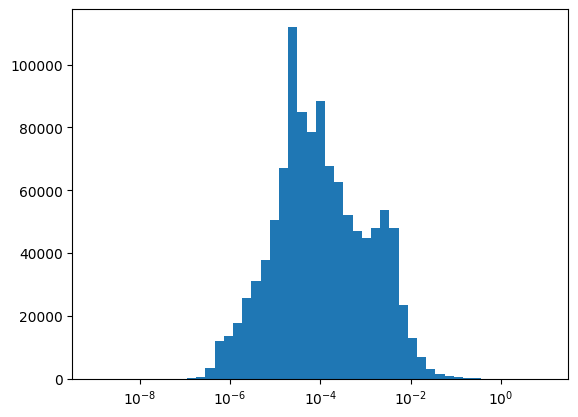

In [17]:
plt.hist(all_kl_t1, bins=np.logspace(-9, 1, 50),)
plt.xscale('log')

In [24]:
result['prob_after_t1']

array([[       nan, 0.        , 0.25585938, ..., 1.        , 1.        ,
        1.        ],
       [       nan, 0.        , 0.25585938, ..., 1.        , 1.        ,
        1.        ],
       [       nan, 0.        , 0.25585938, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [       nan, 0.        , 0.25585938, ..., 1.        , 1.        ,
        1.        ],
       [       nan, 0.        , 0.25585938, ..., 1.        , 1.        ,
        1.        ],
       [       nan, 0.        , 0.25585938, ..., 1.        , 1.        ,
        1.        ]], shape=(25, 1647))

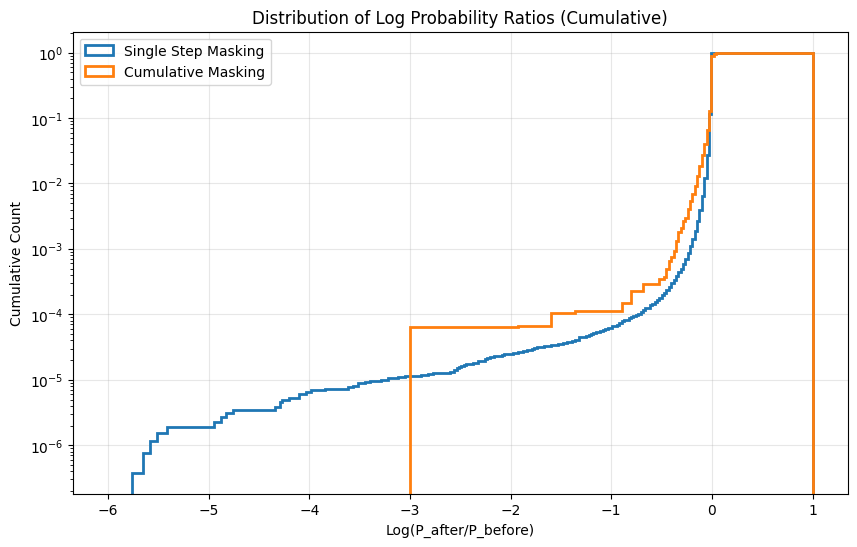

Single step masking: 2616003 data points
Cumulative masking: 2616003 data points


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Function to extract log prob differences safely
def extract_log_prob_diff(results_dict):
    all_log_prob_diff = []

    for (problem_id, is_correct), result in results_dict.items():
        if result is None:
            continue

        # Numerically safe log probability difference
        prob_before = result['prob_before_t1'][None, :]  # Broadcast to (1, n_tokens)
        prob_after = result['prob_after_t1']             # Shape: (n_sentences, n_tokens)

        # Add small epsilon to avoid log(0) and division by 0
        eps = 1e-10
        prob_before_safe = np.maximum(prob_before, eps)
        prob_after_safe = np.maximum(prob_after, eps)

        # Calculate log difference safely
        log_prob_diff = np.log(prob_after_safe) - np.log(prob_before_safe)

        # Filter out invalid values and apply causal mask
        valid_mask = ~np.isnan(log_prob_diff) & ~np.isinf(log_prob_diff)
        causal_and_valid = result['causal_mask'] & valid_mask

        all_log_prob_diff.extend(log_prob_diff[causal_and_valid])

    return np.array(all_log_prob_diff)

# Extract data for both masking types
single_step_log_prob_diff = extract_log_prob_diff(single_step_masking_results)
cumulative_log_prob_diff = extract_log_prob_diff(cumulative_masking_results)

# Create the plot with both lines
bins = np.linspace(-6, 1, 300)

plt.figure(figsize=(10, 6))
plt.hist(single_step_log_prob_diff, bins=bins, histtype='step', cumulative=True,
        label='Single Step Masking', linewidth=2, density=True)
plt.hist(cumulative_log_prob_diff, bins=bins, histtype='step', cumulative=True,
        label='Cumulative Masking', linewidth=2, density = True)

plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Log(P_after/P_before)')
plt.ylabel('Cumulative Count')
plt.title('Distribution of Log Probability Ratios (Cumulative)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Single step masking: {len(single_step_log_prob_diff)} data points")
print(f"Cumulative masking: {len(cumulative_log_prob_diff)} data points")

In [43]:
# cumulative vs single step masking x = token_distance, y = tv_t1

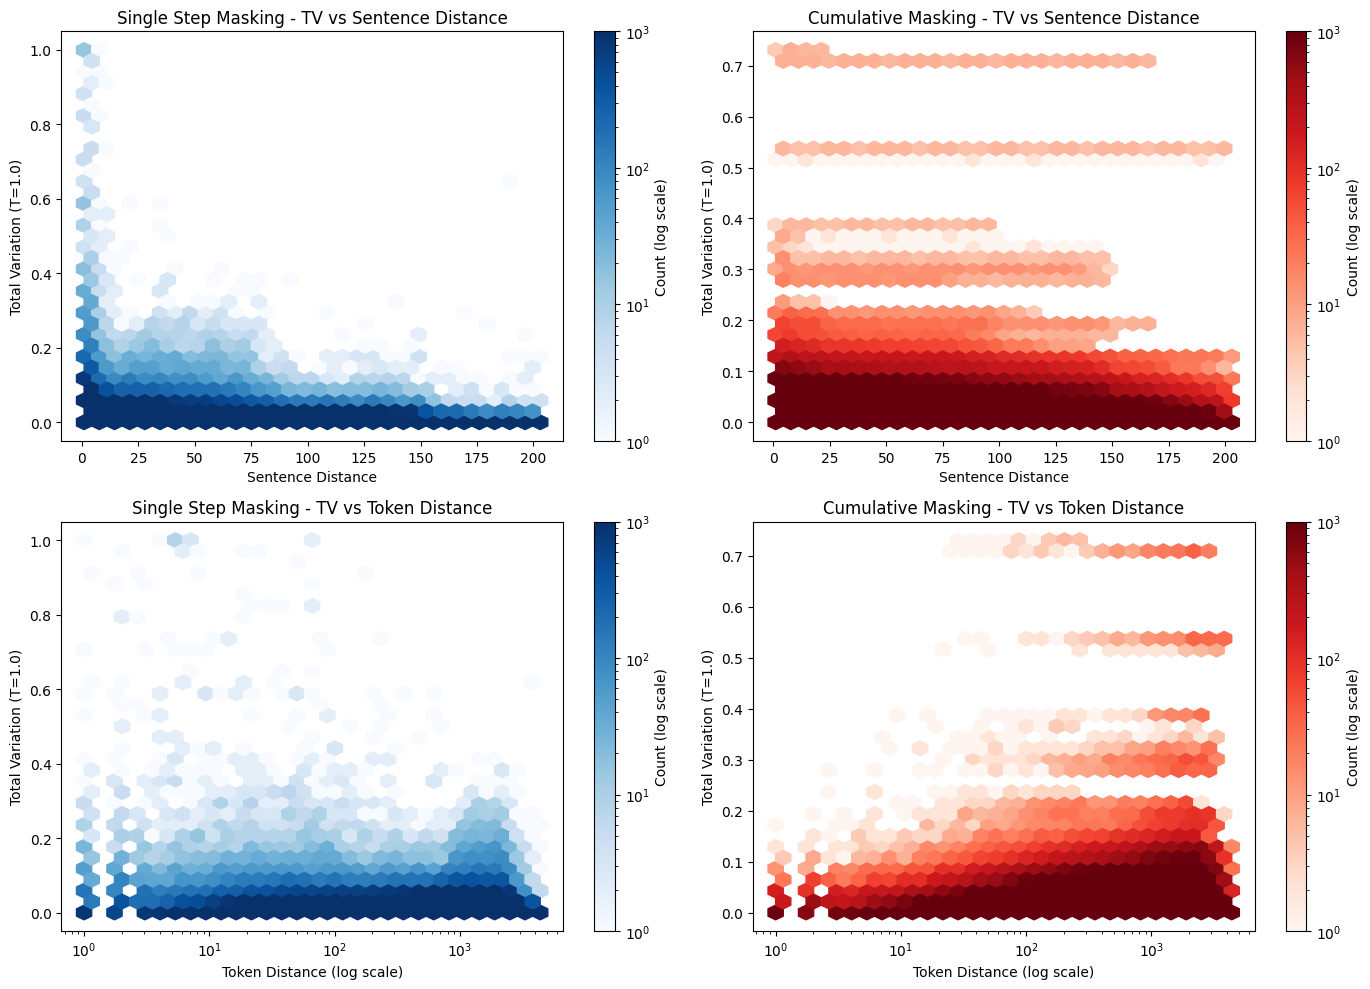

Single step masking: 2616003 data points
Cumulative masking: 2616003 data points


In [46]:
# Function to extract TV and distance data
def extract_tv_distance_data(results_dict):
    all_tv_t1 = []
    all_sentence_distances = []
    all_token_distances = []
    
    for (problem_id, is_correct), result in results_dict.items():
        if result is None:
            continue
        
        # Get causal mask and distances
        causal_mask = result['causal_mask']
        
        # Extract TV data where causal mask is True
        tv_masked = result['tv_matrix_t1'][causal_mask]
        sent_dist_masked = result['sentence_distances'][causal_mask]
        token_dist_masked = result['token_distances'][causal_mask]
        
        # Filter out NaN values
        valid_mask = ~np.isnan(tv_masked)
        
        all_tv_t1.extend(tv_masked[valid_mask])
        all_sentence_distances.extend(sent_dist_masked[valid_mask])
        all_token_distances.extend(token_dist_masked[valid_mask])
    
    return np.array(all_tv_t1), np.array(all_sentence_distances), np.array(all_token_distances)

# Extract data for both masking types
single_tv, single_sent_dist, single_token_dist = extract_tv_distance_data(single_step_masking_results)
cumul_tv, cumul_sent_dist, cumul_token_dist = extract_tv_distance_data(cumulative_masking_results)

# Create side-by-side hexbin plots with log color scale
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sentence distance plots
im1 = axes[0, 0].hexbin(single_sent_dist, single_tv, gridsize=30, cmap='Blues', mincnt=1, 
                        norm=LogNorm(vmin=1, vmax=1000))
axes[0, 0].set_xlabel('Sentence Distance')
axes[0, 0].set_ylabel('Total Variation (T=1.0)')
axes[0, 0].set_title('Single Step Masking - TV vs Sentence Distance')
plt.colorbar(im1, ax=axes[0, 0], label='Count (log scale)')

im2 = axes[0, 1].hexbin(cumul_sent_dist, cumul_tv, gridsize=30, cmap='Reds', mincnt=1,
                        norm=LogNorm(vmin=1, vmax=1000))
axes[0, 1].set_xlabel('Sentence Distance')
axes[0, 1].set_ylabel('Total Variation (T=1.0)')
axes[0, 1].set_title('Cumulative Masking - TV vs Sentence Distance')
plt.colorbar(im2, ax=axes[0, 1], label='Count (log scale)')

# Token distance plots (log scale)
im3 = axes[1, 0].hexbin(single_token_dist, single_tv, gridsize=30, cmap='Blues', mincnt=1, 
                        xscale='log', norm=LogNorm(vmin=1, vmax=1000))
axes[1, 0].set_xlabel('Token Distance (log scale)')
axes[1, 0].set_ylabel('Total Variation (T=1.0)')
axes[1, 0].set_title('Single Step Masking - TV vs Token Distance')
plt.colorbar(im3, ax=axes[1, 0], label='Count (log scale)')

im4 = axes[1, 1].hexbin(cumul_token_dist, cumul_tv, gridsize=30, cmap='Reds', mincnt=1, 
                        xscale='log', norm=LogNorm(vmin=1, vmax=1000))
axes[1, 1].set_xlabel('Token Distance (log scale)')
axes[1, 1].set_ylabel('Total Variation (T=1.0)')
axes[1, 1].set_title('Cumulative Masking - TV vs Token Distance')
plt.colorbar(im4, ax=axes[1, 1], label='Count (log scale)')

plt.tight_layout()
plt.show()

print(f"Single step masking: {len(single_tv)} data points")
print(f"Cumulative masking: {len(cumul_tv)} data points")

In [48]:
result = single_step_masking_results[(1591, True)]

In [53]:
len(result['metadata']['sentences'])

100

# dev text visualization

In [62]:
# Visualize a single result with sentence-level highlighting
def visualize_sentence_dependencies(result, min_distance=3, problem_info=""):
    """
    Highlight sentences by their maximum dependency on far-away sentences.

    Args:
        result: Single problem result dict
        min_distance: Minimum sentence distance to consider as "far away"
        problem_info: String to include in title
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Get the data
    sentences = result['metadata']['sentences']
    prob_before = result['prob_before_t1']
    prob_after = result['prob_after_t1']
    sentence_distances = result['sentence_distances']
    causal_mask = result['causal_mask']

    # Calculate NLL difference for each sentence
    eps = 1e-10
    prob_before_safe = np.maximum(prob_before, eps)
    prob_after_safe = np.maximum(prob_after, eps)

    # NLL = -log(prob), so NLL decrease = log(prob_after) - log(prob_before)
    nll_decrease = np.log(prob_after_safe) - np.log(prob_before_safe[None, :])

    # For each sentence, find max NLL decrease from far-away masking
    n_sentences = len(sentences)
    sentence_scores = np.zeros(n_sentences)

    for sent_idx in range(n_sentences):
        # Find positions where this sentence was masked and effect measured on far sentences
        far_mask = (sentence_distances[sent_idx, :] >= min_distance) & causal_mask[sent_idx, :]

        if np.any(far_mask):
            # Get NLL decreases for tokens in far sentences
            far_nll_decreases = nll_decrease[sent_idx, far_mask]
            # Take maximum decrease (most positive value = biggest improvement)
            sentence_scores[sent_idx] = np.max(far_nll_decreases)
        else:
            sentence_scores[sent_idx] = 0

    # Plot 1: Bar chart of sentence scores
    fig1, ax1 = plt.subplots(1, 1, figsize=(15, 6))

    bars = ax1.bar(range(n_sentences), sentence_scores,
                    color=plt.cm.Reds(sentence_scores / (np.max(sentence_scores) + eps)))
    ax1.set_xlabel('Sentence Index')
    ax1.set_ylabel(f'Max NLL Decrease on Sentences ≥{min_distance} Away')
    ax1.set_title(f'Sentence Dependencies {problem_info}')
    ax1.grid(True, alpha=0.3)

    # Add colorbar
    sm = plt.cm.ScalarMappable
    text_height = max(20, n_sentences * 0.8)  # At least 20, scale with number of sentences
    fig2, ax2 = plt.subplots(1, 1, figsize=(16, text_height))

    # Normalize scores for coloring
    if np.max(sentence_scores) > np.min(sentence_scores):
        norm_scores = (sentence_scores - np.min(sentence_scores)) / (np.max(sentence_scores) - np.min(sentence_scores))
    else:
        norm_scores = np.zeros_like(sentence_scores)

    # Display sentences with proper spacing
    y_positions = np.linspace(n_sentences - 1, 0, n_sentences)  # Space them out evenly

    for i, (sentence, score, y_pos) in enumerate(zip(sentences, norm_scores, y_positions)):
        color = plt.cm.Reds(0.2 + 0.8 * score)  # Start from light red, go to dark red

        # Truncate very long sentences
        if len(sentence) > 120:
            display_text = sentence[:117] + "..."
        else:
            display_text = sentence

        ax2.text(0.02, y_pos, f"[{i:2d}] {display_text}",
                bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.8, edgecolor='darkred', linewidth=0.5),
                fontsize=10, verticalalignment='center', wrap=True,
                transform=ax2.transAxes)  # Use relative coordinates

    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.5, n_sentences - 0.5)
    ax2.axis('off')
    ax2.set_title(f'Sentences Colored by Dependency Score (min_distance={min_distance})',
                fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

    # Print top sentences
    top_indices = np.argsort(sentence_scores)[-5:][::-1]
    print(f"\nTop 5 sentences with highest far-dependency scores:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Sentence {idx} (score: {sentence_scores[idx]:.4f})")
        print(f"   {sentences[idx][:200]}...")
        print()

/tmp/user/21530/ipykernel_4001465/1184964579.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


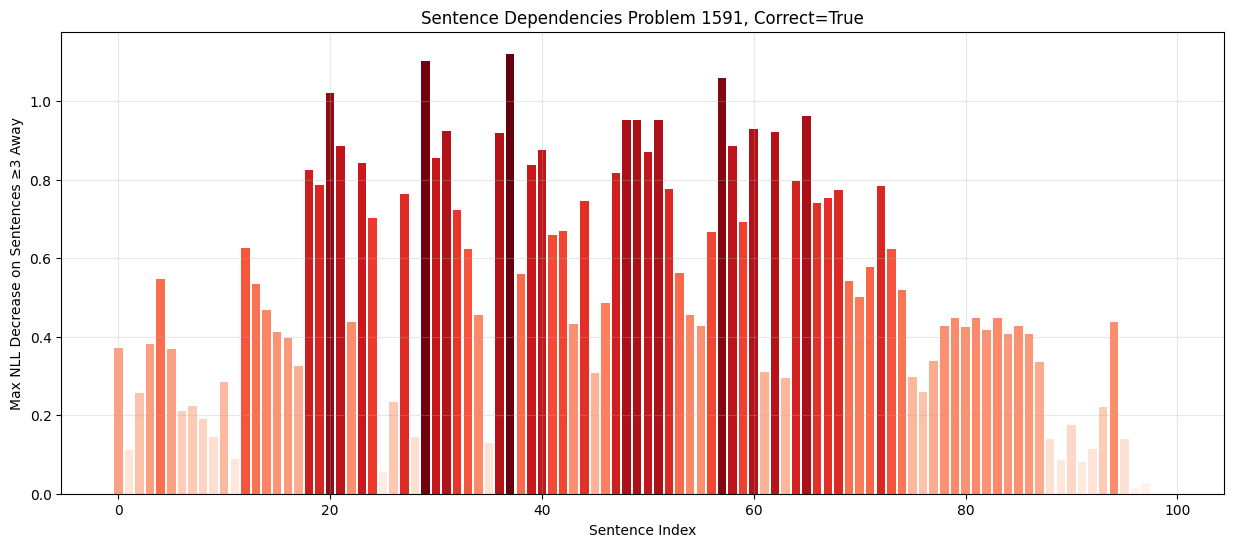


Top 5 sentences with highest far-dependency scores:
1. Sentence 37 (score: 1.1213)
   Let me try to calculate that step by step.

...

2. Sentence 29 (score: 1.1028)
   Let me calculate that:
\( 0.06 \div 12 = 0.005 \)

...

3. Sentence 57 (score: 1.0597)
   Let me use the Taylor series expansion for e^x around x=0.06.

...

4. Sentence 20 (score: 1.0220)
   So we have:
\[ \left(1 + \frac{0.06}{12}\right)^{12 t} = \left(1 + r\right)^t \]

...

5. Sentence 65 (score: 0.9625)
   So, \( e^{0.05985} ≈ e^{0.06} + (-0.00015) e^{0.06} \)
≈ 1.06183654 - 0.00015 * 1.06183654
≈ 1.06183654 - 0.000159775
≈ 1.06167676

...



In [63]:



example_result = single_step_masking_results[(1591, True)]

if example_result is not None:
    visualize_sentence_dependencies(
        example_result,
        min_distance=3,
        problem_info=f"Problem {example_result['metadata']['problem_num']}, Correct={example_result['metadata']['is_correct']}"
    )
else:
    print("No valid result found to visualize")

In [56]:
example_result['metadata']

{'sentences': ['Okay, so I have this problem about Dr. ',
  "Fu Manchu's bank account. ",
  'It says that the account has an annual interest rate of 6 percent, but it compounds monthly. ',
  'I need to find the equivalent annual interest rate, r percent, that would give the same return as the monthly compounding. ',
  'Hmm, let me think about how to approach this.\n\n',
  'First, I remember that compound interest can be calculated using the formula:\n\\[ A = P \\left(1 + \\frac{r}{n}\\right)^n t \\]\nWhere:\n- \\( A \\) is the amount of money accumulated after n years, including interest.\n',
  '- \\( P \\) is the principal amount (the initial amount of money).\n',
  '- \\( r \\) is the annual interest rate (decimal).\n',
  '- \\( n \\) is the number of times that interest is compounded per year.\n',
  '- \\( t \\) is the time the money is invested for in years.\n\n',
  'In this problem, the interest is compounded monthly, so n would be 12. ',
  'The annual interest rate is 6 percent, 